# ADA Greenlight - Creative Extension : Housing, Health and Happiness

-----------------------------------
Due to the lack of random assignment to treatment groups in **observational studies**, omitted variable bias can affect treatment effect estimates. One can therefore question results of regression analyses for such studies, and **sensitivity analysis** allows to quantify the impact of potential omitted variables. In the paper ‘Housing, Health and Happiness”, the matching between treatment and control is not fully transparent, and the lack of sensitivity analysis does not allow to measure its performance.

In this extension, we propose to conduct a **robustness check** to verify the matching through a sensitivity analysis for various matching methods, in order to assess the bias needed to change the results significantly. Specifically, a similar matching as proposed in the paper and a propensity score matching are studied. Finally, analysis of the regressions carried out in the paper for the different matchings can be carried out.

------------------------------------

### Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas.util.testing as tm
import seaborn as sns
import ipywidgets as ipw
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")
import networkx as nx

### Import data

DATA_FOLDER = '../data/'

household_data = pd.read_stata(DATA_FOLDER + 'PisoFirme_AEJPol-20070024_household.dta')

<ipython-input-1-22725afbd338>:10: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Information on Data

In [2]:
### Cleaning the data for optimal matching
# Adjusting to the right number of clusters 
household_data = household_data[household_data["idcluster"].notnull()]

# Dropping rows with NaN values
data_clean = household_data.dropna().reset_index(drop=True)
print('Before removing NaN values: ',  household_data.shape)
print('After removing NaN values: ', data_clean.shape)

# Checking the treatment and control group size 
print('Treatment group size:', len(data_clean[data_clean['dpisofirme'] == 1]))
print('Control group size:', len(data_clean[data_clean['dpisofirme'] == 0]))

Before removing NaN values:  (2755, 78)
After removing NaN values:  (1953, 78)
Treatment group size: 936
Control group size: 1017


## I. Exploring the data - Checking initial balance 

In the paper, the matching between control and treatment is done on the following 4 variables from the 2000 Census variables and using the L-infinite norm: 
* C_blocksdirtfloor
* C_HHdirtfloor
* C_child05
* C_households

We can therefore start by analysing the distribution and properties of the variables from the 2000 Census. In the dataset, they correspond to the variables beginning in 'C_'.
Following their results given in Table 2, we can compute the mean values of treatment and control, as well as the mean difference by aggregating at census block level. In the papers, this is what they use as evidence to show that the data is balanced with their matching, so it is interesting to check these results by replicating this table.

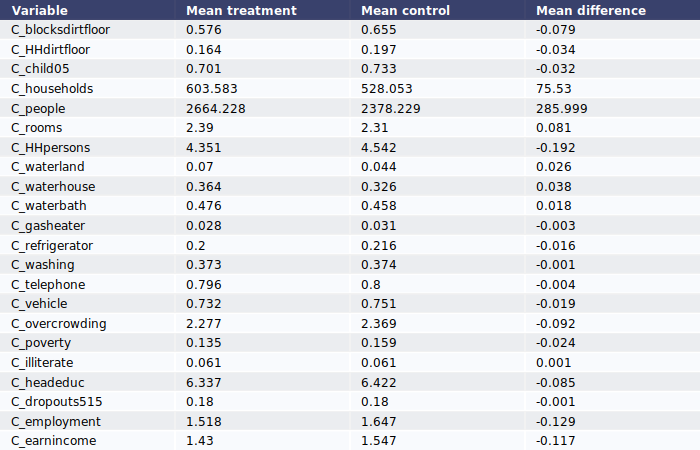

In [24]:
Block_treatment = household_data[household_data['dpisofirme'] == 1].groupby('idmza').mean()
Block_control = household_data[household_data['dpisofirme'] == 0].groupby('idmza').mean()

Table_2 = pd.DataFrame(columns=['Variable', 'Mean treatment', 'Mean control', 'Mean difference'])

for col in Block_control.columns:
    Table_2 = Table_2.append({'Variable':col, 'Mean treatment':np.round(Block_treatment[col].mean(),3),\
                              'Mean control':np.round(Block_control[col].mean(),3),\
                              'Mean difference':np.round(Block_treatment[col].mean()-Block_control[col].mean(),3)},\
                              ignore_index=True)

tab_data = Table_2.iloc[5:27]
fig = ff.create_table(tab_data)
fig.show('svg')
#fig.show()

> The results of the Table are not replicated exactly, but the table shown above is quite close. However, this method does not clearly allow to quantify whether the date is actually balanced, so other methods are proposed below.

### Standardised mean difference (SMD) and t-test

To assess whether balance is achieved between treatment and control, we can look at **standardized mean differences (SMD)**, which is calculated by the difference in the means between the two groups divided by the pooled standard deviation:

$ SMD = \frac{\bar{X}_t - \bar{X}_c}{\sqrt{(s_{t}^2+s_{c}^2)/2}} $

where:
* $\bar{X}_t$, $\bar{X}_c$ denotes the mean of that feature for the treatment and control group respectively. We will use absolute value of this number.
* $s_{t}$, $s_{c}$ denotes the standard deviation of that feature for the treatment and control group respectively.

We can calculate the standardized mean differences for every feature, and if our calculated SMD is 1, then that means there's a 1 standard deviation difference in means. After computing this measurement for all of our features, there is a rule of thumb that are commonly used to determine whether that feature is balanced or not (similar to the 0.05 for p-value idea, which we can also use with a **t-test**): 
* Smaller than  0.1 : For a randomized trial, the smd between all of the covariates should typically fall into this bucket.
* 0.1  -  0.2 : Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose smd fall under this range.
* 0.2 : Values that are greater than this threshold are considered seriously imbalanced.

Although the t-test is too strict to check balance before matching the samples, in this case the given data should correspond to already matched data, and therefore the t-test is also performed.


In [25]:
### Function that creates a table with t-test and SMD results for each column

def create_SMD_table(df):

    from scipy.stats import ttest_ind

    df_mean = pd.DataFrame(columns = ['Variable','T-test p-value','Identical Mean','SMD'])

    for col in df:

        a = df[col][df['dpisofirme'] == 1] # treatment
        b = df[col][df['dpisofirme'] == 0] # control
        ttest = ttest_ind(a, b, equal_var = False, nan_policy = 'omit')
        
        if (ttest.pvalue < 0.05):
            identical_mean = False
        else:
            identical_mean = True

        df_mean = df_mean.append({'Variable':col, 'T-test p-value':ttest.pvalue, 'Identical Mean':identical_mean,\
                                 'SMD': np.round(np.abs(a.mean() - b.mean())/(np.sqrt((np.square(a.std())+np.square(b.std()))/2)),3)}, ignore_index=True)

    
    return df_mean
    

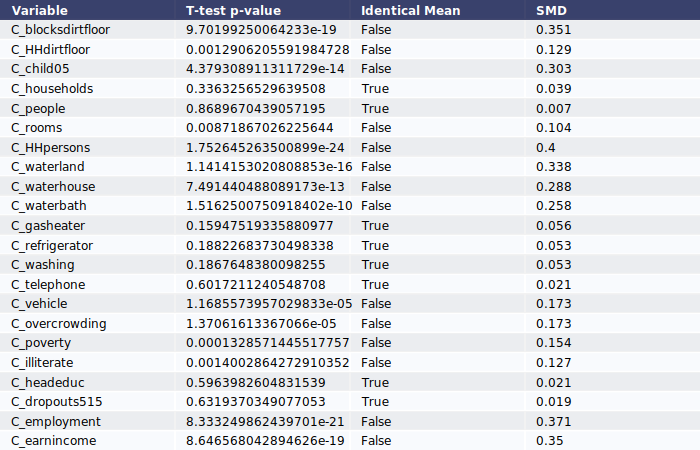

In [26]:
### Checking the balance of the initial household_data

df_SMD_initial = create_SMD_table(household_data)

tab_data = df_SMD_initial.iloc[6:28]
fig = ff.create_table(tab_data)
fig.show('svg')

In [27]:
### Function that creates a graphical reprensentation of t-test results from the table

def create_ttest_fig(df):
    import plotly.express as px
    data = df.iloc[6:28]

    fig = px.bar(data, x='Variable', y='T-test p-value', color='Identical Mean', height=500)
    fig.update_layout(
            {'title_text': '<b>'+'Balanced Data Check - T-test'+'</b>',
                'xaxis': dict(tickangle=45)})
    fig.show("svg")
    #fig.show()

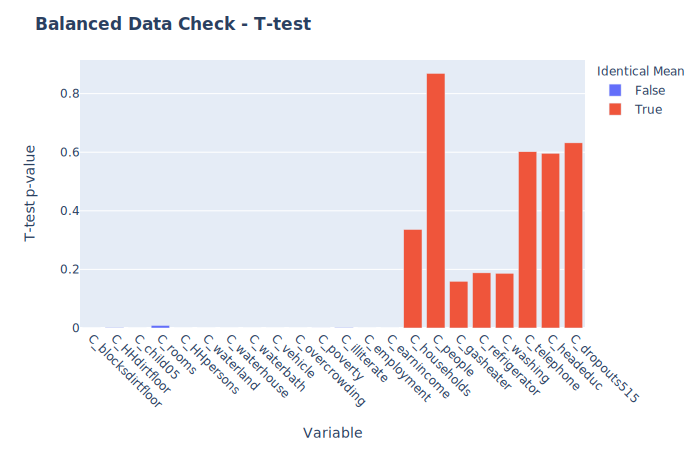

In [28]:
create_ttest_fig(df_SMD_initial)

In [52]:
### Function that creates a graphical reprensentation of the SMD results from the table

def create_SMD_fig(df, title, filename): 

    import plotly.express as px
    data = df.iloc[6:28]

    fig = px.bar(data, x='Variable', y='SMD', height=500, color='SMD')
    fig.update_layout(
            {'title_text': '<b>'+title+'</b>',
                'xaxis': dict(tickangle=45)})
    
    fig.show('svg')
    #fig.show()
    fig.write_html(filename + '.html')

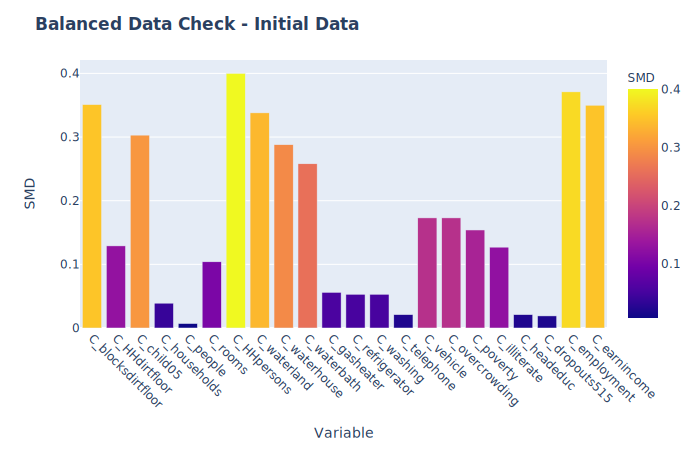

In [30]:
create_SMD_fig(df_SMD_initial,'Balanced Data Check - Initial Data', 'InitialSMD')

It appears that **3 of the 4 variables used for the matching are not balanced** according to the t-test results, as the statistical test yields a p-value below the threshold of 0.05 for C_blocksdirtfloor, C_HHdirtfloor and C_child05, indicating that we must reject the null hypothesis of equal averages, and that the SMD is above 0.1 or 0.2 for C_blocksdirtfloor, C_HHdirtfloor and C_child05. This puts into question the matching that was done in the paper for the study, and **validates the research question of this study to further explore matching and conduct a sensitivity analysis.**


## II. Matching  

For observationa studied, the distribution of **confounders** typically differs between treatment groups, as we have just seen, which is expected as it is not a randomised trial. Confounders are defined as variables that affect both treatment and outcome, and an important assumption in the estimation of causal effect is the ignorability assumption: given pre-treatment covariates, treatment assignment is independent of the potential outcome, also known as the “no unmeasured confounders’ assumption”.

To solve the issue of the confounder distributions, **matching** is performed. Matching is a technique that attempts to control for confounding and make an observational study more like a randomised trial, and the idea is to match individuals in the treated group with similar individuals in the control group for the covariates. However, we can’t exactly match on the full set of covariates, so what is often done is try and make sure the distributions are balanced between the groups, known as stochastic balance.

### A. Replicating the paper's matching

They use the maximum of the absolute value of differences between the following four variables for each pair of treatment and control blocks :
* C_blocksdirtfloor
* C_HHdirtfloor
* C_child05
* C_households

We want to minimise this distance. We can reduce the minimum weight matching to a maximum weight matching by multiplying all edge weights in the graph by -1.

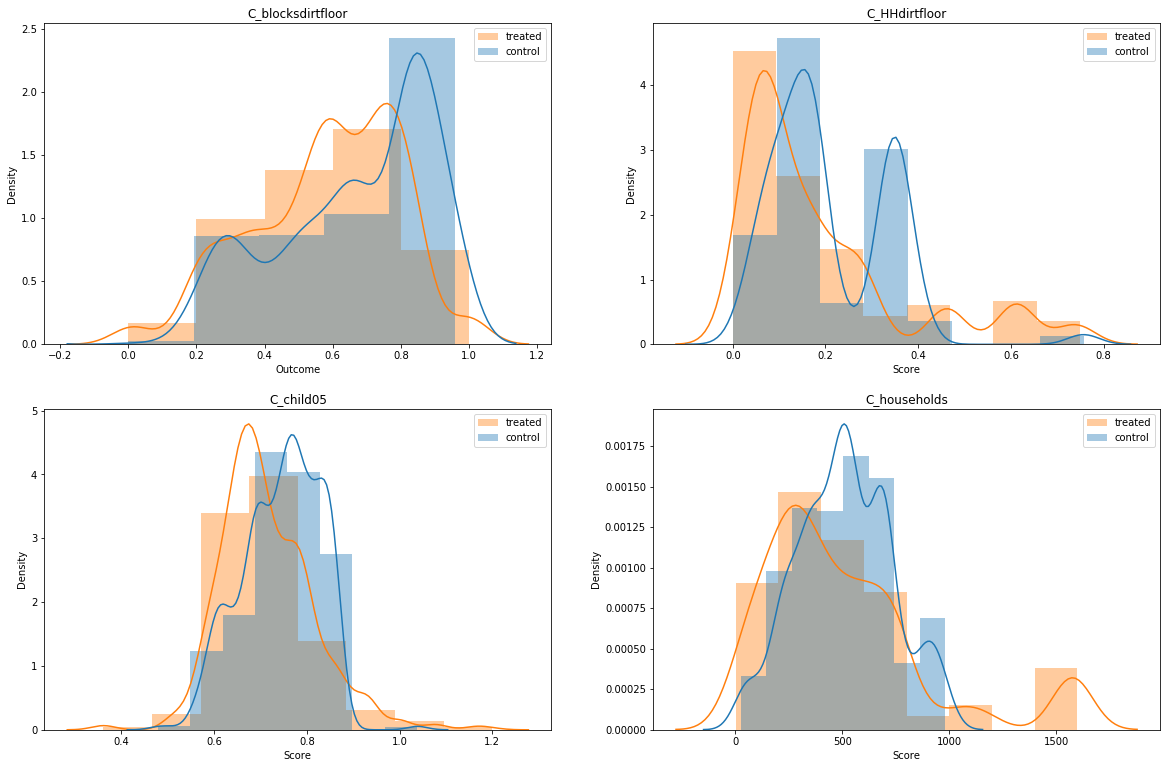

In [48]:
### Show the distribution of the variables **before** the matching

pos_blocksdirtfloor = data_clean['C_blocksdirtfloor'][data_clean['dpisofirme']==1]
neg_blocksdirtfloor = data_clean['C_blocksdirtfloor'][data_clean['dpisofirme']==0]

pos_HHdirtfloor = data_clean['C_HHdirtfloor'][data_clean['dpisofirme']==1]
neg_HHdirtfloor = data_clean['C_HHdirtfloor'][data_clean['dpisofirme']==0]

pos_child05 = data_clean['C_child05'][data_clean['dpisofirme']==1]
neg_child05 = data_clean['C_child05'][data_clean['dpisofirme']==0]

pos_households = data_clean['C_households'][data_clean['dpisofirme']==1]
neg_households = data_clean['C_households'][data_clean['dpisofirme']==0]


fig, axes = plt.subplots(2, 2, figsize=(20, 13))

# 'C_blocksdirtfloor'
sns.distplot(pos_blocksdirtfloor, hist=True, color='tab:orange', ax=axes[0][0], bins=5);
sns.distplot(neg_blocksdirtfloor, hist=True, color='tab:blue', ax=axes[0][0], bins=5)
axes[0][0].set(title='C_blocksdirtfloor',\
            xlabel='Outcome', ylabel='Density')
axes[0][0].legend(labels=["treated","control"])

# 'C_HHdirtfloor'
sns.distplot(pos_HHdirtfloor, hist=True, color='tab:orange', ax=axes[0][1], bins=8);
sns.distplot(neg_HHdirtfloor, hist=True, color='tab:blue', ax=axes[0][1], bins=8)
axes[0][1].set(title='C_HHdirtfloor',\
            xlabel='Score', ylabel='Density')
axes[0][1].legend(labels=["treated","control"]);

# 'C_child05'
sns.distplot(pos_child05, hist=True, color='tab:orange', ax=axes[1][0], bins=8);
sns.distplot(neg_child05, hist=True, color='tab:blue', ax=axes[1][0], bins=8)
axes[1][0].set(title='C_child05',\
            xlabel='Score', ylabel='Density')
axes[1][0].legend(labels=["treated","control"]);

# 'C_households'
sns.distplot(pos_households, hist=True, color='tab:orange', ax=axes[1][1], bins=8);
sns.distplot(neg_households, hist=True, color='tab:blue', ax=axes[1][1], bins=8)
axes[1][1].set(title='C_households',\
            xlabel='Score', ylabel='Density')
axes[1][1].legend(labels=["treated","control"]);

In [31]:
def get_max_difference(diff1, diff2, diff3, diff4):
    '''Calculate L-infifnite distance'''
    max_diff = max(abs(diff1), abs(diff2), abs(diff3), abs(diff4))
    return max_diff

In [32]:
treated = data_clean[data_clean['dpisofirme'] == 1] #People that attained the program
control = data_clean[data_clean['dpisofirme'] == 0] #People that didn't attain the program

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of samples
for control_id, control_row in control.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        # Calculate the L-infinite difference
        max_dist = get_max_difference(control_row['C_child05'] - treatment_row['C_child05'], \
                        control_row['C_blocksdirtfloor'] - treatment_row['C_blocksdirtfloor'], \
                        control_row['C_HHdirtfloor'] - treatment_row['C_HHdirtfloor'], \
                        control_row['C_households'] - treatment_row['C_households'])
        
        min_dist = -max_dist
        
        # Add an edge between the two samples weighted by minus the L-infinite distance
        G.add_weighted_edges_from([(control_id, treatment_id, min_dist)])

# Generate and return the maximum weight matching on the graph
matching_paper = nx.max_weight_matching(G, maxcardinality=True)

In [33]:
# Matching summary
print("Number of treated households : ", len(treated))
print("Number of control households : ", len(control))
print("Number of pairs matched : ", len(matching_paper))
print("Number of pairs NOT matched : ", len(treated)-len(matching_paper))

Number of treated households :  936
Number of control households :  1017
Number of pairs matched :  936
Number of pairs NOT matched :  0


In [34]:
df_matched_paper = data_clean.iloc[[subj_id for t in matching_paper for subj_id in t]]

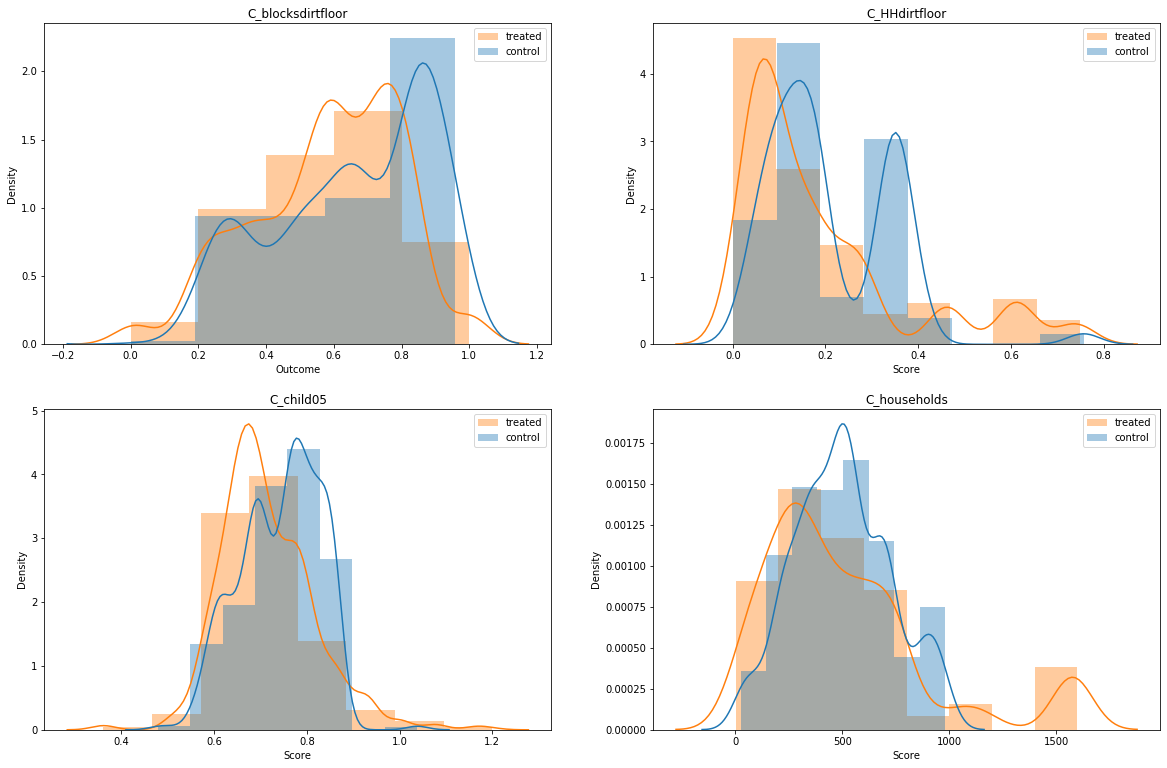

In [50]:
### Show the distribution of the variables **after** the matching

pos_blocksdirtfloor = df_matched_paper['C_blocksdirtfloor'][df_matched_paper['dpisofirme']==1]
neg_blocksdirtfloor = df_matched_paper['C_blocksdirtfloor'][df_matched_paper['dpisofirme']==0]

pos_HHdirtfloor = df_matched_paper['C_HHdirtfloor'][df_matched_paper['dpisofirme']==1]
neg_HHdirtfloor = df_matched_paper['C_HHdirtfloor'][df_matched_paper['dpisofirme']==0]

pos_child05 = df_matched_paper['C_child05'][df_matched_paper['dpisofirme']==1]
neg_child05 = df_matched_paper['C_child05'][df_matched_paper['dpisofirme']==0]

pos_households = df_matched_paper['C_households'][df_matched_paper['dpisofirme']==1]
neg_households = df_matched_paper['C_households'][df_matched_paper['dpisofirme']==0]


fig, axes = plt.subplots(2, 2, figsize=(20, 13))

# 'C_blocksdirtfloor'
sns.distplot(pos_blocksdirtfloor, hist=True, color='tab:orange', ax=axes[0][0], bins=5);
sns.distplot(neg_blocksdirtfloor, hist=True, color='tab:blue', ax=axes[0][0], bins=5)
axes[0][0].set(title='C_blocksdirtfloor',\
            xlabel='Outcome', ylabel='Density')
axes[0][0].legend(labels=["treated","control"])

# 'C_HHdirtfloor'
sns.distplot(pos_HHdirtfloor, hist=True, color='tab:orange', ax=axes[0][1], bins=8);
sns.distplot(neg_HHdirtfloor, hist=True, color='tab:blue', ax=axes[0][1], bins=8)
axes[0][1].set(title='C_HHdirtfloor',\
            xlabel='Score', ylabel='Density')
axes[0][1].legend(labels=["treated","control"]);

# 'C_child05'
sns.distplot(pos_child05, hist=True, color='tab:orange', ax=axes[1][0], bins=8);
sns.distplot(neg_child05, hist=True, color='tab:blue', ax=axes[1][0], bins=8)
axes[1][0].set(title='C_child05',\
            xlabel='Score', ylabel='Density')
axes[1][0].legend(labels=["treated","control"]);

# 'C_households'
sns.distplot(pos_households, hist=True, color='tab:orange', ax=axes[1][1], bins=8);
sns.distplot(neg_households, hist=True, color='tab:blue', ax=axes[1][1], bins=8)
axes[1][1].set(title='C_households',\
            xlabel='Score', ylabel='Density')
axes[1][1].legend(labels=["treated","control"]);
fig.savefig("matching_paper_dist_after.png")

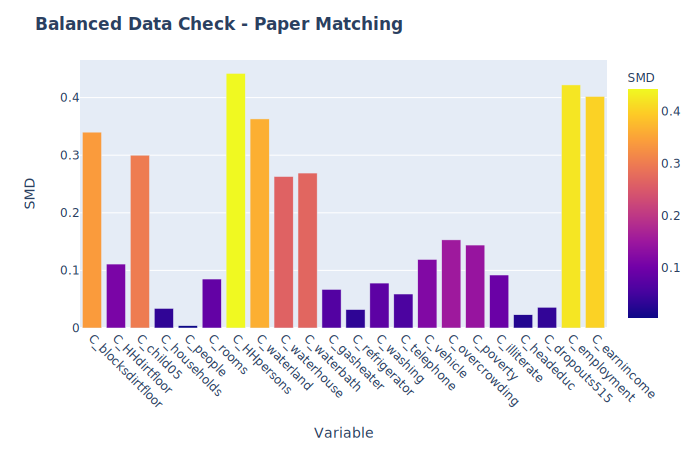

In [53]:
### Looking at the SMD disitribution after matching - Paper variables

df_SMD_matched_paper = create_SMD_table(df_matched_paper)
create_SMD_fig(df_SMD_matched_paper, 'Balanced Data Check - Paper Matching', 'PaperSMD')

### B. Propensity Score Matching 

Another method used for matching is based on what is called **propensity score**. In this case, the goal is that the two samples of the pair have the same probability to be treated. For subject $l$, the probability of being treated given full knowledge of the world is : 

$\pi_{l} = \mathbb{P}(Z_{l} = 1 \mid r_{Cl}, r_{Tl}, x_{l}, u_{l})$

with $Z_l$ the treatment assignment, $r_{Cl}$ the response if the subject is control, $r_{Tl}$ the response if the subject is treated, $x_{l}$ the observed covariates and $u_{l}$ the unobserved covariates. Instead of matching on observed covariates directly, the idea is to reduce the information of all the pre-treatment covariates to one single number called the propensity score. This number is computed for every sample using a **logistic regression**. By doing so, the samples with equal propensity score are guaranted to have equal distributions of observed variables. The samples in the same pair might not have equal $x$, but total treatment and control groups will have the same distribution. 

The variables used for the matching are the **pre-treatment** variables, and in this case they correspond to the 2000 Census variables. Before matching these variables using the propensity score, we can standardise them.

In [54]:
### Continuous features from 2000 census - used for matching

cont_features = ['C_blocksdirtfloor', 'C_HHdirtfloor', 'C_child05', 'C_households',
       'C_people', 'C_rooms', 'C_HHpersons', 'C_waterland', 'C_waterhouse',
       'C_waterbath', 'C_gasheater', 'C_refrigerator', 'C_washing',
       'C_telephone', 'C_vehicle', 'C_overcrowding', 'C_poverty',
       'C_illiterate', 'C_headeduc', 'C_dropouts515', 'C_employment',
       'C_earnincome']

In [55]:
### Creation of a dataframe to standardise continuous features used for the matching

norm_data = data_clean.copy()

# standardisation of the continuous features
for x in cont_features:
    norm_data[x] = (norm_data[x]-norm_data[x].mean())/norm_data[x].std()
    
norm_data.head(5)

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,0.0,70000537.0,-103.503670,25.583067,7.0,40,-1.447455,-1.031417,-1.865365,0.972799,...,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487
1,0.0,70000537.0,-103.503670,25.583067,7.0,47,-1.447455,-1.031417,-1.865365,0.972799,...,20.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390
2,0.0,70000537.0,-103.503670,25.583067,7.0,47,-1.447455,-1.031417,-1.865365,0.972799,...,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778
3,0.0,70000537.0,-103.503670,25.583067,7.0,41,-1.447455,-1.031417,-1.865365,0.972799,...,25.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,4.605170,8.517193
4,0.0,70000679.0,-103.489845,25.578873,7.0,34,-1.595467,-1.069433,-0.810466,-0.581706,...,16.0,19.0,1.0,0.0,1.0,0.0,0.0,1.0,7.313221,11.512925


For the propensity score matching, two options are studied: firstly, replicating the paper's matching using the **4 census variables** used prior, as well as a second propensity score matching utilising **all census variables**. They will respectively be called '_paper' and '_all' is the following code.

In [56]:
### Computing the propensity scores

mod_prop_4 = smf.logit(formula='dpisofirme ~ C_blocksdirtfloor + C_HHdirtfloor + C_child05 + C_households', \
                                                                                              data=norm_data)

mod_prop_all = smf.logit(formula='dpisofirme ~ C_blocksdirtfloor +  C_HHdirtfloor +  C_child05 +  C_households + \
                                    C_rooms +  C_HHpersons +  C_waterland +  C_waterhouse + C_waterbath +\
                                   C_gasheater +  C_refrigerator +  C_washing + C_telephone +  C_vehicle +\
                                    C_overcrowding +  C_poverty + C_illiterate +  C_headeduc +  C_dropouts515 +\
                                    C_employment + C_earnincome + C_people',  data=norm_data)


res_prop_4 = mod_prop_4.fit()
res_prop_all = mod_prop_all.fit()

norm_data_4 = norm_data.copy().reset_index(drop=True)
norm_data_4['P_score'] = res_prop_4.predict()

norm_data_all = norm_data.copy().reset_index(drop=True)
norm_data_all['P_score'] = res_prop_all.predict()

Optimization terminated successfully.
         Current function value: 0.661942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.328380
         Iterations 8


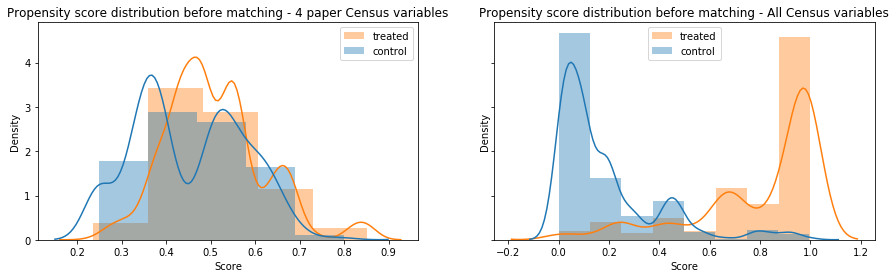

In [57]:
### Show the distribution of the P-scores **before** the matching, in both cases (4 variables and all variables)

pos_pscore_4 = norm_data_4['P_score'][norm_data_4['dpisofirme']==1]
neg_pscore_4 = norm_data_4['P_score'][norm_data_4['dpisofirme']==0]

pos_pscore_all = norm_data_all['P_score'][norm_data_all['dpisofirme']==1]
neg_pscore_all = norm_data_all['P_score'][norm_data_all['dpisofirme']==0]


fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# Paper variables
sns.distplot(pos_pscore_4, hist=True, color='tab:orange', ax=axes[0], bins=5);
sns.distplot(neg_pscore_4, hist=True, color='tab:blue', ax=axes[0], bins=5)
axes[0].set(title='Propensity score distribution before matching - 4 paper Census variables',\
            xlabel='Score', ylabel='Density')
axes[0].legend(labels=["treated","control"])

# All variables
sns.distplot(pos_pscore_all, hist=True, color='tab:orange', ax=axes[1], bins=8);
sns.distplot(neg_pscore_all, hist=True, color='tab:blue', ax=axes[1], bins=8)
axes[1].set(title='Propensity score distribution before matching - All Census variables',\
            xlabel='Score', ylabel='Density')
axes[1].legend(labels=["treated","control"]);
fig.savefig("prop_dist_before.png")

In [58]:
### Function that computes the similarity score given two propensity score values

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [59]:
### Function that creates the matching given a dataframe and threshold for the similarity

def create_matching(df, threshold):
    
    # Separate the treatment and control groups
    treatment_df = df[df['dpisofirme'] == 1]
    control_df = df[df['dpisofirme'] == 0]

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

            # Calculate the similarity 
            similarity = get_similarity(control_row['P_score'],
                                        treatment_row['P_score'])

            # Add an edge between the two instances weighted by the similarity between them
            if (similarity > threshold):
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    return matching

In [60]:
### Create the matching for the two studied cases of propensity scores

matching_prop_4 = create_matching(norm_data_4, 0.)
matching_prop_all = create_matching(norm_data_all, 0.)

In [61]:
### Create dataframes with the matched samples

df_matched_prop_4 = norm_data_4.iloc[[subj_id for t in matching_prop_4 for subj_id in t]]
df_matched_prop_all = norm_data_all.iloc[[subj_id for t in matching_prop_all for subj_id in t]]

print('Matched samples with four paper variables: ', len(df_matched_prop_4))
print('Matched samples with all variables: ', len(df_matched_prop_all))

Matched samples with four paper variables:  1872
Matched samples with all variables:  1872


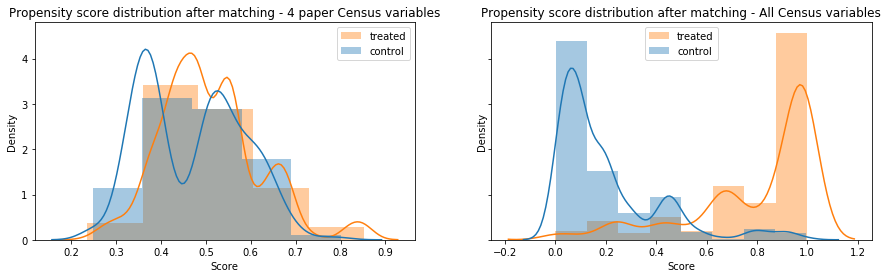

In [106]:
### Show the distribution of the P-scores **after** the matching, in both cases (4 variables and all variables)

pos_pscore_prop_4 = df_matched_prop_4['P_score'][df_matched_prop_4['dpisofirme']==1]
neg_pscore_prop_4 = df_matched_prop_4['P_score'][df_matched_prop_4['dpisofirme']==0]

pos_pscore_prop_all = df_matched_prop_all['P_score'][df_matched_prop_all['dpisofirme']==1]
neg_pscore_prop_all = df_matched_prop_all['P_score'][df_matched_prop_all['dpisofirme']==0]


fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# Paper variables
sns.distplot(pos_pscore_prop_4, hist=True, color='tab:orange', ax=axes[0], bins=5);
sns.distplot(neg_pscore_prop_4, hist=True, color='tab:blue', ax=axes[0], bins=5)
axes[0].set(title='Propensity score distribution after matching - 4 paper Census variables',\
            xlabel='Score', ylabel='Density')
axes[0].legend(labels=["treated","control"])

# All variables
sns.distplot(pos_pscore_prop_all, hist=True, color='tab:orange', ax=axes[1], bins=8);
sns.distplot(neg_pscore_prop_all, hist=True, color='tab:blue', ax=axes[1], bins=8)
axes[1].set(title='Propensity score distribution after matching - All Census variables',\
            xlabel='Score', ylabel='Density')
axes[1].legend(labels=["treated","control"]);
fig.savefig("prop_dist_after.png")

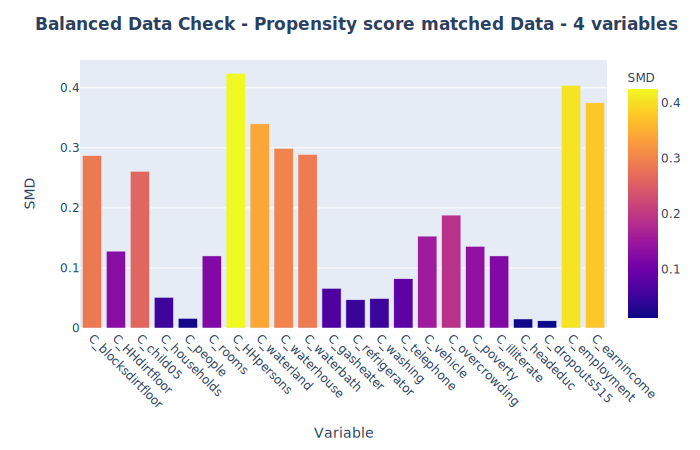

In [63]:
### Looking at the SMD disitribution after matching - Paper variables

df_SMD_matched_prop_4 = create_SMD_table(df_matched_prop_4)
create_SMD_fig(df_SMD_matched_prop_4, 'Balanced Data Check - Propensity score matched Data - 4 variables', 'Pmatched4SMD')

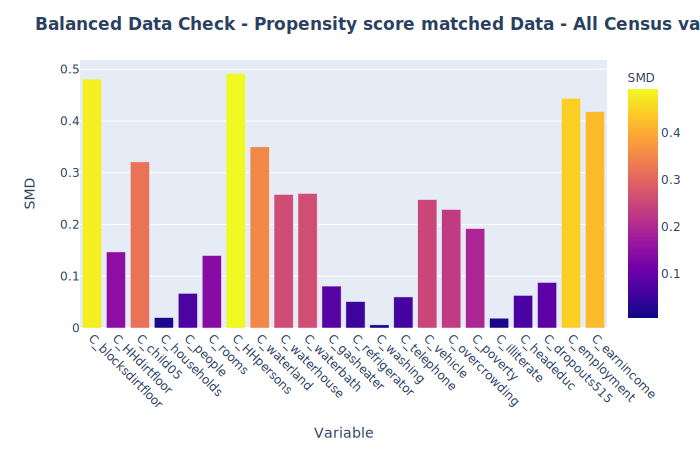

In [64]:
### Looking at the SMD disitribution after matching - All variables

df_SMD_matched_prop_all = create_SMD_table(df_matched_prop_all)
create_SMD_fig(df_SMD_matched_prop_all, 'Balanced Data Check - Propensity score matched Data - All Census variables',\
               'PmatchedAllSMD')

# III. Sensitivity Analysis

Matching can improve the veracity of the results. It ensures that similar samples are compared, i.e. they are similar in terms of observed variables. Nevertheless, there might be some unobserved covariates that highly differ between the two samples. In other words, a **naive model** assumes that the probability to be treated was $0.5$ inside the pairs treated-control. However, there might exists an unmeasured confounder that could unbalance this probability by favouring one sample or the other. **Sensitivity analysis** allows to quantify the degree to which the naive model is wrong. 

The intuition is that the naive model would be wrong if there exists a confounder sufficiently important to modify the probability of being treated by a certain amount. Let's be more precise - the model assumes that the odds of two similar data points are bounded by a factor $\Gamma$ : $ \frac{1}{\Gamma} \leq \frac{\pi_k(1 - \pi_k)}{\pi_l(1 - \pi_l)} \leq \Gamma $.

For each value of $\Gamma$, we use a statistical test with the following hypotheses :
* $H_0$ : No treatment effect on the model.
* $H_1$ : A treatment effect on the model.

If the $p$-value $< 0.05$, we can reject the null hypothesis $H_0$ of no treatment effect. We start with $\Gamma = 1$ and then increase its value. Under the null hypothesis, increasing $\Gamma$ increases the $p$-value. Finding the smallest $\Gamma$ for which $p > 0.05$ corresponds to finding by how much would the probability have to depart from $0.5$ to obtain a $p$-value above $0.05$ so that the hypothesis of no treatment effect cannot be rejected. Therefore, estimating a value for $\Gamma$ allows to evaluate the likelihood of a potential hidden covariate and the consequence of this covariate on the results.

### Creating data for the sensitivity analysis on R

The sensitivity analysis on the matching will be carried out on R, using the `sensitivitymv` library by P. Rosenbaum. To do so, we need to create a csv file containing two columns, one for treatment and one for control. Each row corresponds to one matched pair, where column 1 is the outcome for the treatment case the other column is the outcome for the control.

In order to study the sensitivity of the outcomes to an initial bias, we need to select the outcomes we want to study. In this case, we can look at the outcomes studied in the paper and used to conclude on the treatment effect, corresponding to the regressed outcomes in Tables 4 and 6 of the paper. 

In [72]:
### Function that creates the dataframe with treatment and control outcomes in two columns

def create_sensitivity_data(b1, b2, outcome):
    treat = []
    cont = []
    for i in range(0, len(b1)): 
        if(b1.iloc[i]['dpisofirme'] == 1):
            treat.append(b1.iloc[i][outcome])
            cont.append(b2.iloc[i][outcome])
        else:
            treat.append(b2.iloc[i][outcome])
            cont.append(b1.iloc[i][outcome])
    return pd.DataFrame({'Treatment': treat, 'Control': cont})

In [73]:
### Create the csv files needed for the sensitivity analysis

# outcome variables studied with the sensitivity analysis, from Tables 4 and 6 in the paper
outcome_var = ['S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin', 'S_cementfloorbat', 'S_cementfloorbed',\
                      'S_satisfloor', 'S_satishouse', 'S_satislife', 'S_cesds', 'S_pss']

for x in outcome_var:
    
    # Replication of paper matching
    dictio_paper = dict(matching_paper)
    b1_paper = data_clean.iloc[list(dictio_paper.keys())].reset_index(drop=True)
    b2_paper = data_clean.iloc[list(dictio_paper.values())].reset_index(drop=True)

    X_paper = create_sensitivity_data(b1_paper, b2_paper, x)
    X_paper.to_csv('data_sensitivity_analysis/X_paper_' + x + '.csv', index=False)
    
    # Propensity score matching with all variables
    dictio_prop_all = dict(matching_prop_all)
    b1_prop_all = norm_data_all.iloc[list(dictio_prop_all.keys())].reset_index(drop=True)
    b2_prop_all = norm_data_all.iloc[list(dictio_prop_all.values())].reset_index(drop=True)

    X_prop_all = create_sensitivity_data(b1_prop_all, b2_prop_all, x)
    X_prop_all.to_csv('data_sensitivity_analysis/X_propall_' + x + '.csv', index=False)
    
    # Propensity score matching with the 4 variables of the paper
    dictio_prop_4 = dict(matching_prop_4)
    b1_prop_4 = norm_data_4.iloc[list(dictio_prop_4.keys())].reset_index(drop=True)
    b2_prop_4 = norm_data_4.iloc[list(dictio_prop_4.values())].reset_index(drop=True)

    X_prop_4 = create_sensitivity_data(b1_prop_4, b2_prop_4, x)
    X_prop_4.to_csv('data_sensitivity_analysis/X_prop4_' + x + '.csv', index=False)

### Sensitivity Analysis Results 

After performing the sensitivity analysis for the two different matching methods and on all of the studied outcomes (from Tables 4 and 6 of the paper and looking at the most predicting outcomes in terms of unexplained variance), we can now visualise the results and comment on the overall robustness towards bias. 

In [74]:
### Loading the results obtained with R using the senmv function

Res_tab = pd.read_excel('Results_Tabs_All.xlsx')
Res_pred = pd.read_excel('Results_predicting.xlsx')

In [75]:
Res_tab

,S_shcementfloor,S_cementfloorkit,S_cementfloordin,S_cementfloorbat,S_cementfloorbed,S_satisfloor,S_satishouse,S_satislife,S_cesds,S_pss
gamma_paper,3.250000,4.310000,3.060000,1.890000,3.310000,1.943000,1.250000,1.301000,1.0,1.0
p_value_paper,0.050216,0.050339,0.050380,0.050006,0.050635,0.050142,0.050561,0.050101,1.0,1.0
gamma_all,3.200000,4.230000,3.020000,1.822000,3.120000,1.916000,1.207000,1.290000,1.0,1.0
p_value_all,0.050275,0.050576,0.050809,0.050564,0.050708,0.050218,0.050770,0.050635,1.0,1.0
gamma_4,3.460000,4.390000,3.035000,2.016000,3.345000,1.902000,1.224000,1.325000,1.0,1.0
p_value_4,0.050931,0.050921,0.050571,0.050194,0.050683,0.050296,0.050190,0.050668,1.0,1.0


In [76]:
def create_sens_fig(df):
    
    from plotly import graph_objs as go

    df_fig1 = df.sort_values(by='gamma_paper', axis=1, ascending=True)
    df_fig2 = df.sort_values(by='gamma_all', axis=1, ascending=True)
    df_fig3 = df.sort_values(by='gamma_4', axis=1, ascending=True)

    fig = go.Figure()

    trace1 = go.Bar(x=df_fig1.columns, y=df_fig1.iloc[0], name='Paper matching')
    trace2 = go.Bar(x=df_fig2.columns, y=df_fig2.iloc[2], name='P-score matching - All Census variables')
    trace3 = go.Bar(x=df_fig3.columns, y=df_fig3.iloc[4], name='P-score matching - 4 Census variables')

    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.add_trace(trace3)

    fig.update_layout(
            {'title_text': '<b>'+'Sensitivity to Bias'+'</b>',
                'xaxis': dict(title='Outcomes', tickangle=45),
                'yaxis_title_text': 'Gamma'})

    #fig.show()
    fig.show('svg')
    #fig.write_html('Gamma_fig.html')

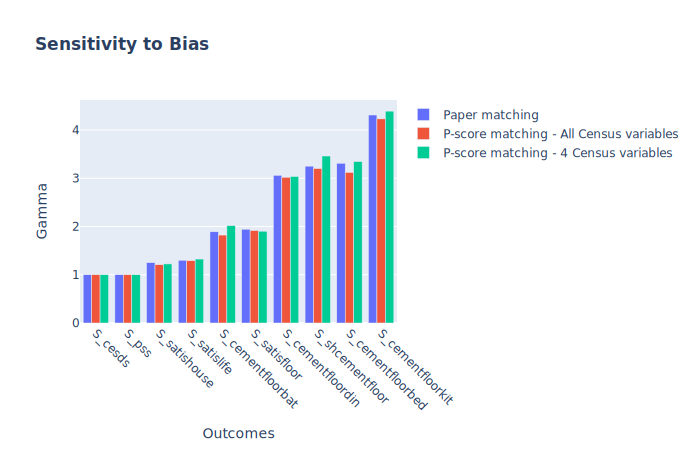

In [77]:
create_sens_fig(Res_tab)

### Amplification of sensitivity analysis

Let's concentrate on the outcome S_shcementfloor. We measure a sensitivity of $\Gamma = 3.25$ using the matching of the paper. It corresponds to a probability of treatment comprised in $[\frac{1}{1 + \Gamma}, \frac{\Gamma}{1 + \Gamma} ] = [0.23, 0.76 ]$ which would violate the hypothesis of randomised treatment assignment.

In [3]:
Gamma = 3.25
Lambda = np.linspace(3.3, 10, 50)
Delta = (1-Gamma*Lambda)/(Gamma - Lambda)

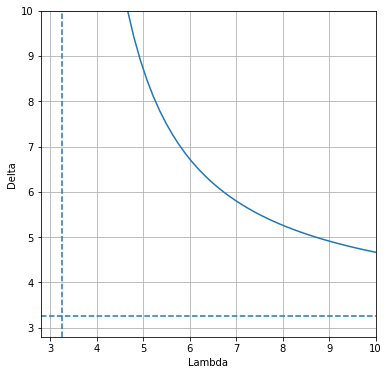

In [4]:
fig = plt.figure(figsize=(6,6))
plt.plot(Lambda, Delta)
plt.axvline(x=Gamma, ls='--', color='tab:blue')
plt.axhline(y=Gamma, ls='--', color='tab:blue')
plt.xlim([min(Lambda)-0.5, max(Lambda)])
plt.ylim([min(Lambda)-0.5, max(Lambda)])
plt.xlabel('Lambda')
plt.ylabel('Delta')
plt.grid()
plt.show()
fig.savefig('amplification.png', dpi=100, bbox_inches = "tight")

All combinaisons $(\Lambda, \Delta)$ such that $\Gamma = 3.25$ form the blue curve. The vertical and horizontam dashed lines corresponds to $\Gamma = 3.25$, which is also the asymptotes of the curve, when taking one of the parameter going to $\infty$. All combinaisons above the curve lead to $p < 0.05$ which means that the treatment have significant effects. On the opposite, all combinaisons below the curve lead to $p > 0.05$ which means that there are no significant effect of the treatment. Let's take an example. $(\Lambda, \Delta) = (6, 7)$ corresponds to an unobserved covariate that would multiply by $6$ the odds of treatment and multiply the odds of a positive pair difference in the outcomes by $7$.

### Benchmark Analysis - Most influential regressors

As we've discussed, omitted variable bias can affect treatment effect estimates obtained from observational data due to the lack of random assignment to treatment groups. **Sensitivity analyses** adjust these estimates to quantify the impact of the non-randomised assignement and the potential omitted variables.
As a first step of a sensitivity analysis, one can use benchmarking: the use of available data to establish reference points for speculation about omitted confounders. 
In this case, we look at the effect of regressors used in the linear regression models proposed in the paper on R^2. We can isolate each variable of the models and see the change incurred in R^2 when the regressors are not included in the model. This enables a classification of the most predictive regressors in terms of R^2. Indeed, the difference in R^2 corresponds to the **bias that would have been incurred by omitting said variable in the model**. We can then use this information to select the outcome variables which will be studied in the sensitivity analysis of the matching, which will be carried out using the **senmv package on R**. 

In [79]:
### Function which allows to delete the z^th regressor of the model x 
### Creates the necessary string to input in the statsmodel linear regression

def create_mod_str(x,z):
    output_str = ''
    for i in range(0,len(x)):
        if((i != z) and (i != len(x)-1)):
            output_str = output_str + x[i] + ' + '
        if(i == len(x)-1):
            output_str = output_str + x[i]
    return output_str

In [80]:
### Function that creates the Table comparing the effect of the regressors

def R2_Table(mod_variables, mod_regressors, model, dataset, col_names):

    ### Creating a Dataframe to collect the data
    R2_df = pd.DataFrame(columns = col_names).reset_index()
    R2_df['index'] = mod_variables
    
    
    for i in range(0,5):
    
        # Declaring the complete Model
        mod = smf.ols(formula = mod_variables[i] + ' ~ ' + model, data = dataset.fillna(0))
        
        # Fitting Model
        np.random.seed(2)
        res = mod.fit(cov_type = 'cluster', cov_kwds={'groups': dataset.fillna(0)['idcluster']})
        R2 = res.rsquared
        R2_df['Total Model R2'].iloc[i] = R2
        
    
        for j in range(len(mod_regressors)):
    
            # Declaring the Model
            mod = smf.ols(formula = mod_variables[i] + ' ~ ' + 'C(dpisofirme) + '+ create_mod_str(mod_regressors,j),\
                      data = dataset.fillna(0))

            # Fitting Model
            np.random.seed(2)
            res = mod.fit(cov_type = 'cluster', cov_kwds={'groups': dataset.fillna(0)['idcluster']})
            R2 = res.rsquared
            R2_df[mod_regressors[j]].iloc[i] = 100*((1-R2)-(1-R2_df['Total Model R2'].iloc[i]))/(1-R2_df['Total Model R2'].iloc[i])

    return R2_df

In [81]:
### Computing the omitted variable bias for model 3 and the variables of Table 4 and 6 

# Looking at Model 3 for Tables 4 and 6 of the paper

mod_variables_T4 = ['S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin', 'S_cementfloorbat', 'S_cementfloorbed']
mod_variables_T6 = ['S_satisfloor', 'S_satishouse', 'S_satislife', 'S_cesds', 'S_pss']

mod_regressors = ['S_HHpeople', 'S_headage','S_spouseage','S_headeduc',\
                  'S_spouseeduc', 'S_dem1','S_dem2','S_dem3','S_dem4','S_dem5','S_dem6','S_dem7','S_dem8',\
                  'C(S_waterland)','C(S_waterhouse)','C(S_electricity)','C(S_hasanimals)','C(S_animalsinside)',\
                  'C(S_garbage)', 'S_washhands', 'S_cashtransfers', 'C(S_milkprogram)', 'C(S_foodprogram)',\
                  'C(S_seguropopular)']

col_names = ['Total Model R2', 'S_HHpeople', 'S_headage','S_spouseage','S_headeduc',\
                  'S_spouseeduc', 'S_dem1','S_dem2','S_dem3','S_dem4','S_dem5','S_dem6','S_dem7','S_dem8',\
                  'C(S_waterland)','C(S_waterhouse)','C(S_electricity)','C(S_hasanimals)','C(S_animalsinside)',\
                  'C(S_garbage)', 'S_washhands', 'S_cashtransfers', 'C(S_milkprogram)', 'C(S_foodprogram)',\
                  'C(S_seguropopular)']

model3 = 'C(dpisofirme) + S_HHpeople + S_headage + S_spouseage + \
                     S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 \
                     + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + \
                     C(S_animalsinside) + C(S_garbage) + S_washhands + S_cashtransfers + C(S_milkprogram) +\
                     C(S_foodprogram) + C(S_seguropopular)'

Tab_R2_4 = R2_Table(mod_variables_T4, mod_regressors, model3, household_data, col_names)
Tab_R2_6 = R2_Table(mod_variables_T6, mod_regressors, model3, household_data, col_names)

Tab_R2_4.drop(['index','Total Model R2'], axis=1).sort_values(by=0, axis=1, ascending=False);
Tab_R2_6.drop(['index','Total Model R2'], axis=1).sort_values(by=0, axis=1, ascending=False);

In [82]:
### Function that creates a visualisation of the results for the bias analysis

def Plot_R2(R2_df, title):

    from plotly import graph_objs as go

    variables = R2_df['index']
    counter = 0;
    R2_fig = R2_df.drop(['index','Total Model R2'], axis=1)

    fig = go.Figure()

    for vb in variables:
    
        if(counter != 0):
            trace = go.Bar(x=R2_fig.sort_values(by=counter, axis=1, ascending=False).columns, y=R2_fig.sort_values(by=counter, axis=1, ascending=False).iloc[counter], name=vb, visible = "legendonly")
        if(counter == 0):
            trace = go.Bar(x=R2_fig.sort_values(by=counter, axis=1, ascending=False).columns, y=R2_fig.sort_values(by=counter, axis=1, ascending=False).iloc[counter], name=vb)
        
        fig.add_trace(trace)
    
        counter=counter+1

    fig.update_layout(
        {'title_text': '<b>'+'Reduction in unexplained variance - Table '+title+'</b>',
            'xaxis': dict(title='Regressors', tickangle=45),
            'yaxis_title_text': 'reduction in unexplained variance [%]'})
    
    #fig.show()
    fig.show('svg')
    #fig.write_html('Bias_Figure_T'+title+'.html')

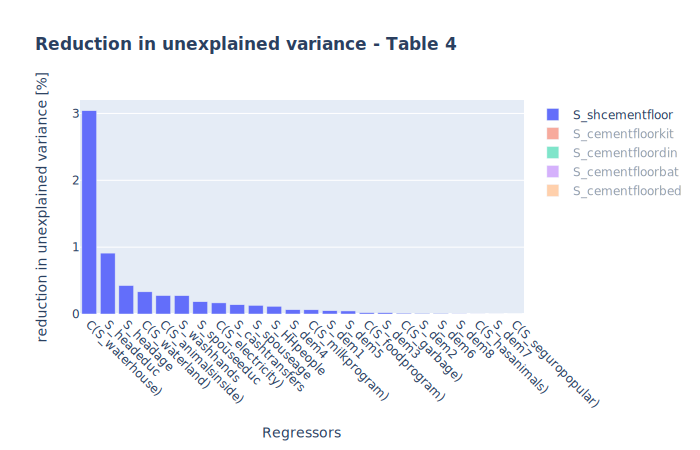

In [83]:
Plot_R2(Tab_R2_4, '4')

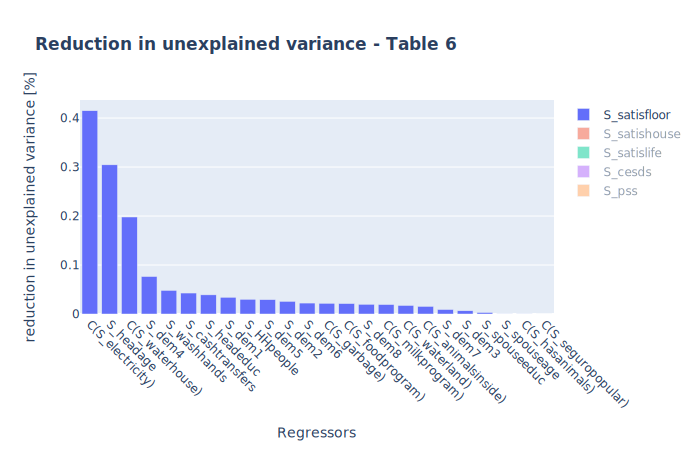

In [84]:
Plot_R2(Tab_R2_6, '6')

We observe that the outcome variables **S_waterhouse**, **S_headeduc**, **S_HHpeople** are the most predicting in for the studied variables in Tables 4

For Table 6, **S_electricity**, **S_waterhouse**, **S_garbage** are the most important in terms of changes to the unexplained variance.